In [2]:
import os 
import time
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt 

from train_mlp_ae import * 
# from trainer import AE_Trainer
from trainer_02 import AE_Trainer
from mlp_ae import MLPVAE, MLP_VQVAE, vae_loss, vqvae_loss
from cnn_ae import CNN_VAE

## Plotting Function

In [3]:
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt

def plot_losses(directory_list, legend, title1=None, title2=None, max_loss=None, time_scale=20):
    """
    Plots training and validation losses from a list of directories.
    
    Args:
        directory_list (list): List of paths to experiment directories.
        legend (list): List of strings for the legend labels.
        max_loss (float, optional): If provided, clips loss values > max_loss.
        time_scale (float, optional): The maximum value for the x-axis (e.g., 20).
                                      Data will be scaled to fit 0 to time_scale.
    """
    
    # Initialize two separate figures
    fig_train, ax_train = plt.subplots(figsize=(10, 6))
    fig_val, ax_val = plt.subplots(figsize=(10, 6))
    
    counter = 0
    
    # Iterate through each directory provided
    for directory in directory_list:
        if not os.path.exists(directory):
            print(f"Warning: Directory '{directory}' not found. Skipping.")
            continue

        # Get list of .npy files in the directory
        try:
            files = [f for f in os.listdir(directory) if f.endswith('.npy')]
        except NotADirectoryError:
             print(f"Warning: '{directory}' is not a directory. Skipping.")
             continue

        # Identify train and validation files based on keywords
        train_file = next((f for f in files if 'log_' in f.lower()), None)
        val_file = next((f for f in files if 'val' in f.lower()), None)
        
        print(f"Found training file indicator: {train_file} in {directory}")
        
        # Use the directory name as the label for the plot legend
        label_name = os.path.basename(os.path.normpath(directory))
        current_legend = legend[counter] if counter < len(legend) else label_name

        # --- Process Training Data ---
        if train_file:
            train_path = os.path.join(directory, "losses.npy")
            
            if os.path.exists(train_path):
                train_data = np.load(train_path)
                
                # 1. Handle Clipping
                if max_loss is not None:
                    if train_data.ndim == 1:
                        train_data = np.minimum(train_data, max_loss)
                    elif train_data.ndim == 2:
                        train_data[:, 1] = np.minimum(train_data[:, 1], max_loss)

                # 2. Handle Time Scaling (Attaching X-axis array)
                x_vals = None
                y_vals = None
                
                if train_data.ndim == 1:
                    # Case: 1D Data (Loss only)
                    y_vals = train_data
                    # Explicitly create an array from 0 to time_scale
                    if len(y_vals) > 0:
                        x_vals = np.linspace(0, time_scale, len(y_vals))
                    else:
                        x_vals = np.array([])
                elif train_data.ndim == 2:
                    # Case: 2D Data (Time, Loss)
                    x_raw = train_data[:, 0]
                    y_vals = train_data[:, 1]
                    # Normalize existing time column to 0 - time_scale
                    if len(x_raw) > 0:
                        x_min, x_max = x_raw.min(), x_raw.max()
                        if x_max > x_min:
                            x_vals = (x_raw - x_min) / (x_max - x_min) * time_scale
                        else:
                            x_vals = np.zeros_like(x_raw)
                    else:
                         x_vals = np.array([])

                # Plot with the attached x-scale
                ax_train.plot(x_vals, y_vals, label=current_legend)
            else:
                print(f"Expected 'losses.npy' not found in {directory}")
        else:
            print(f"No training file found in {directory}")

        # --- Process Validation Data ---
        if val_file:
            val_path = os.path.join(directory, val_file)
            val_data = np.load(val_path)
            
            # 1. Handle Clipping
            if max_loss is not None:
                if val_data.ndim == 1:
                    val_data = np.minimum(val_data, max_loss)
                elif val_data.ndim == 2:
                    val_data[:, 1] = np.minimum(val_data[:, 1], max_loss)

            # 2. Handle Time Scaling
            x_vals_val = None
            y_vals_val = None
            
            if val_data.ndim == 1:
                y_vals_val = val_data
                if len(y_vals_val) > 0:
                    x_vals_val = np.linspace(0, time_scale, len(y_vals_val))
                else:
                    x_vals_val = np.array([])
            elif val_data.ndim == 2:
                x_raw = val_data[:, 0]
                y_vals_val = val_data[:, 1]
                if len(x_raw) > 0:
                    x_min, x_max = x_raw.min(), x_raw.max()
                    if x_max > x_min:
                        x_vals_val = (x_raw - x_min) / (x_max - x_min) * time_scale
                    else:
                        x_vals_val = np.zeros_like(x_raw)
                else:
                    x_vals_val = np.array([])

            ax_val.plot(x_vals_val, y_vals_val, label=current_legend)
        else:
            print(f"No validation file found in {directory}")
            
        counter += 1

    # --- Formatting Training Plot ---
    ax_train.set_title("Training Losses Comparison")
    ax_train.set_xlabel(f"Scaled Time (0-{time_scale})")
    ax_train.set_ylabel("Loss")
    if max_loss:
        title = title1 + f"(Clipped at {max_loss})"
        ax_train.set_title(title)
    
    # Increased legend size here
    ax_train.legend(fontsize=16)
    ax_train.grid(True, alpha=0.3)

    # --- Formatting Validation Plot ---
    ax_val.set_title("Validation Losses Comparison")
    ax_val.set_xlabel(f"Scaled Time (0-{time_scale})")
    ax_val.set_ylabel("Loss")
    if max_loss:
        title = title2 + f"(Clipped at {max_loss})"
        ax_val.set_title(title)
    
    # Increased legend size here
    ax_val.legend(fontsize=16)
    ax_val.grid(True, alpha=0.3)

    plt.show()

## Hyperparameter Sweep

### Learning Rate Sweep

In [2]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [11, 1]
ac_dim = [31, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 

NameError: name 'LatentActionBuffer' is not defined

In [ ]:
model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 20}

learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
for lr in learning_rates:
    optim_params["lr"] = lr
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"cnn_lr_sweep_{lr}")
    trainer.train_loop(train_loader, val_loader,1000, arch="conv")

{'log_freq': 100, 'save_freq': 1000, 'epochs': 20, 'lr': 0.1}
Starting training for 20 epochs, 1000 steps per epoch.
Step 100 | Logged Loss: 0.09931
Step 200 | Logged Loss: 0.06760
Step 300 | Logged Loss: 0.06415
Step 400 | Logged Loss: 0.06063
Step 500 | Logged Loss: 0.05924
Step 600 | Logged Loss: 0.05603
Step 700 | Logged Loss: 0.05456
Step 800 | Logged Loss: 0.05082
Step 900 | Logged Loss: 0.04762
Step 1000 | Logged Loss: 0.04412
Step 1000 | Val Loss: 0.04311 | Saving checkpoint...
End of Epoch 0 | Avg Epoch Loss: 0.06041
Step 1100 | Logged Loss: 0.04178
Step 1200 | Logged Loss: 0.04115
Step 1300 | Logged Loss: 0.04063
Step 1400 | Logged Loss: 0.04042
Step 1500 | Logged Loss: 0.03953
Step 1600 | Logged Loss: 0.03933
Step 1700 | Logged Loss: 0.03906
Step 1800 | Logged Loss: 0.03890
Step 1900 | Logged Loss: 0.03858
Step 2000 | Logged Loss: 0.03769
Step 2000 | Val Loss: 0.03803 | Saving checkpoint...
End of Epoch 1 | Avg Epoch Loss: 0.03971
Step 2100 | Logged Loss: 0.03760
Step 2200 |

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.1
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.01
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.001
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.0001
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_lr_sweep_1e-05


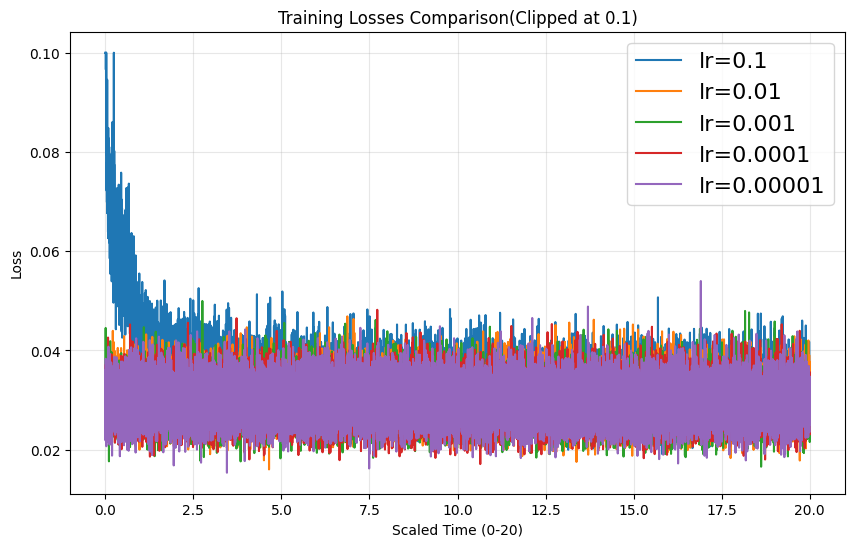

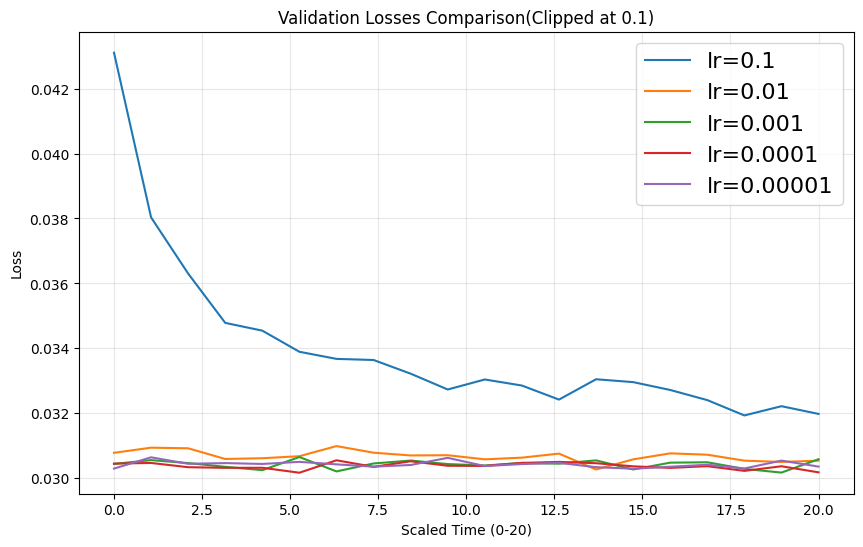

In [ ]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.1',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.01',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.001', 
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_0.0001',
    '/home/blank/cs282_project/latent_actions/cnn_lr_sweep_1e-05' 
    ]
plot_losses(directories_to_plot, ["lr=0.1","lr=0.01","lr=0.001", "lr=0.0001", "lr=0.00001"], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

### Batch Size Sweep

In [ ]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 20,
                "lr": 0.001}


    

batch_sizes = [10, 20, 50, 100, 150]

for size in batch_sizes:
    train_loader = DataLoader(action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10)
    val_loader = DataLoader(val_action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10) 
    test_loader = DataLoader(test_action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10) 
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"cnn_batch_size_sweep_{size}")
    trainer.train_loop(train_loader, val_loader, 1000, arch="conv")

Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 155.72it/s]


Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 171.19it/s]


Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 150.14it/s]


{'log_freq': 100, 'save_freq': 1000, 'epochs': 20, 'lr': 0.001}
Starting training for 20 epochs, 1000 steps per epoch.
Step 100 | Logged Loss: 0.30001
Step 200 | Logged Loss: 0.20146
Step 300 | Logged Loss: 0.15802
Step 400 | Logged Loss: 0.13017
Step 500 | Logged Loss: 0.10891
Step 600 | Logged Loss: 0.10017
Step 700 | Logged Loss: 0.09280
Step 800 | Logged Loss: 0.08806
Step 900 | Logged Loss: 0.08487
Step 1000 | Logged Loss: 0.08231
Step 1000 | Val Loss: 0.08015 | Saving checkpoint...
End of Epoch 0 | Avg Epoch Loss: 0.13468
Step 1100 | Logged Loss: 0.08042
Step 1200 | Logged Loss: 0.07929
Step 1300 | Logged Loss: 0.07702
Step 1400 | Logged Loss: 0.07554
Step 1500 | Logged Loss: 0.07407
Step 1600 | Logged Loss: 0.07283
Step 1700 | Logged Loss: 0.07257
Step 1800 | Logged Loss: 0.07096
Step 1900 | Logged Loss: 0.07116
Step 2000 | Logged Loss: 0.06966
Step 2000 | Val Loss: 0.06918 | Saving checkpoint...
End of Epoch 1 | Avg Epoch Loss: 0.07435
Step 2100 | Logged Loss: 0.06890
Step 2200

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_10
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_20
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_50
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_100
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_150


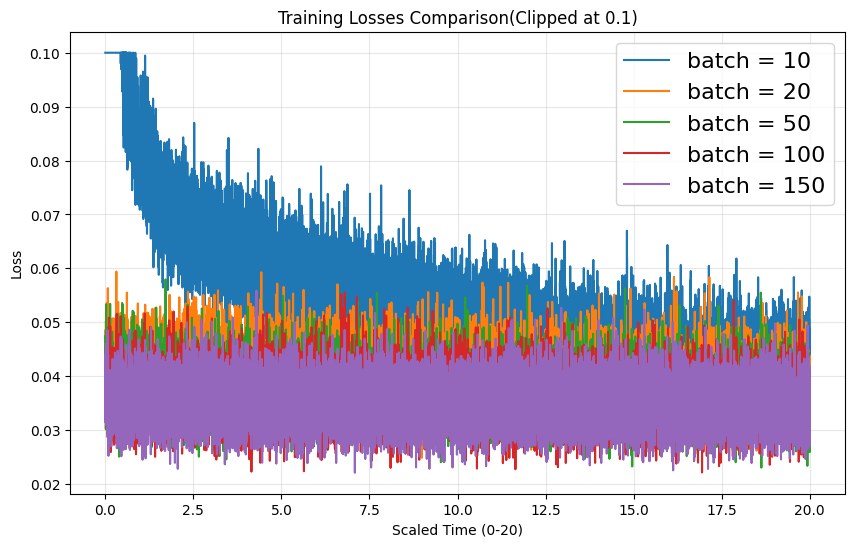

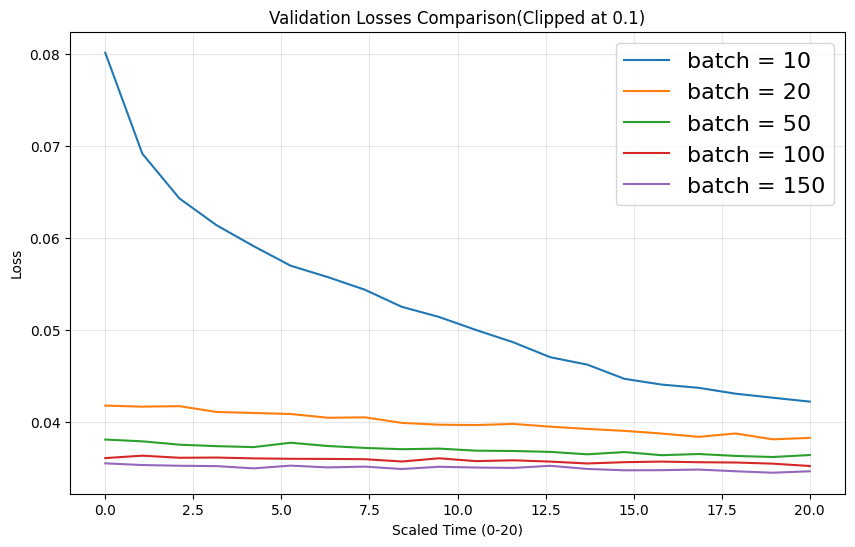

In [ ]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_10', 
    '/home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_20',
    '/home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_50',
    '/home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_100',
    '/home/blank/cs282_project/latent_actions/cnn_batch_size_sweep_150' 
    ]
plot_losses(directories_to_plot, ["batch = 10", "batch = 20", "batch = 50", "batch = 100","batch = 150" ], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

In [4]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 
train_loader = DataLoader(action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                batch_size = batch_size, 
                                shuffle = True, 
                                num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                batch_size = batch_size, 
                                shuffle = True, 
                                num_workers=10) 

model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 50,
                "lr": 0.002}
betas = [0.1, 0.2, 0.4 , 0.6, 0.7, 0.8, 0.9]
for i,beta in enumerate(betas):
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"cnn_beta_sweep_{i}",
                         "VAE", dist_reg = beta)
    trainer.train_loop(train_loader, val_loader, 1000, arch="conv")

Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 142.13it/s]


Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 198.11it/s]


Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 184.95it/s]


{'log_freq': 100, 'save_freq': 1000, 'epochs': 50, 'lr': 0.002}
Starting training for 50 epochs, 1000 steps per epoch.
Step 100 | Logged Loss: 0.25946
Step 200 | Logged Loss: 0.11715
Step 300 | Logged Loss: 0.08677
Step 400 | Logged Loss: 0.07666
Step 500 | Logged Loss: 0.06843
Step 600 | Logged Loss: 0.06336
Step 700 | Logged Loss: 0.05996
Step 800 | Logged Loss: 0.05478
Step 900 | Logged Loss: 0.05343
Step 1000 | Logged Loss: 0.05145
Step 1000 | Val Loss: 0.04976 | Saving checkpoint...
End of Epoch 0 | Avg Epoch Loss: 0.08915
Step 1100 | Logged Loss: 0.04887
Step 1200 | Logged Loss: 0.04795
Step 1300 | Logged Loss: 0.04654
Step 1400 | Logged Loss: 0.04597
Step 1500 | Logged Loss: 0.04474
Step 1600 | Logged Loss: 0.04350
Step 1700 | Logged Loss: 0.04280
Step 1800 | Logged Loss: 0.04246
Step 1900 | Logged Loss: 0.04279
Step 2000 | Logged Loss: 0.04163
Step 2000 | Val Loss: 0.04088 | Saving checkpoint...
End of Epoch 1 | Avg Epoch Loss: 0.04473
Step 2100 | Logged Loss: 0.04051
Step 2200

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_beta_sweep_0
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_beta_sweep_1
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_beta_sweep_2
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_beta_sweep_3
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_beta_sweep_4
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_beta_sweep_5
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/cnn_beta_sweep_6


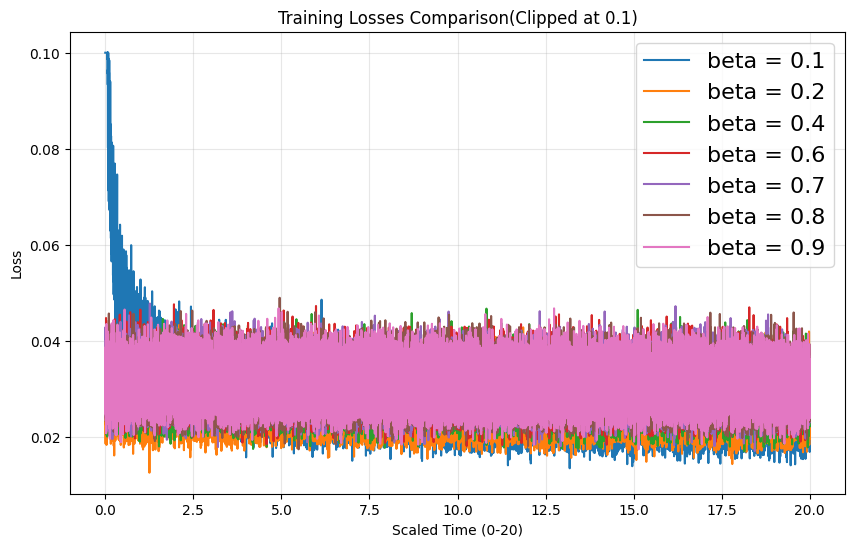

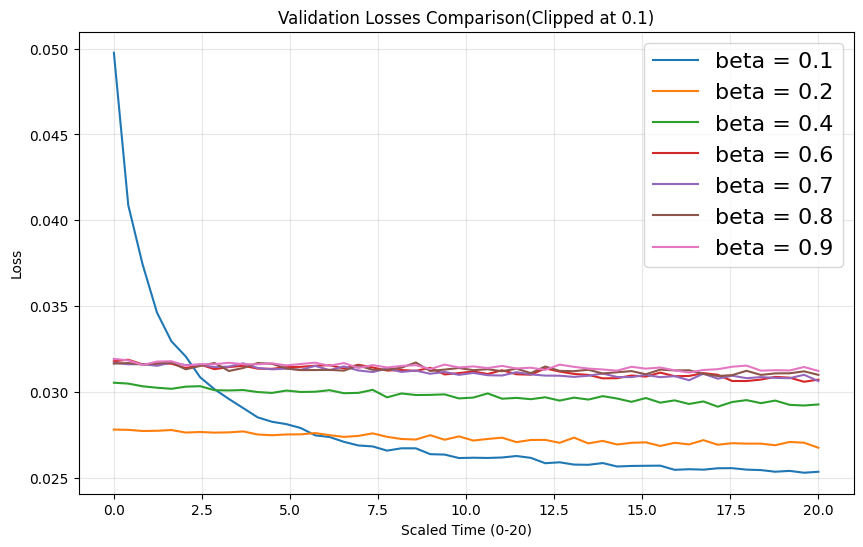

In [6]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/cnn_beta_sweep_0', 
    '/home/blank/cs282_project/latent_actions/cnn_beta_sweep_1',
    '/home/blank/cs282_project/latent_actions/cnn_beta_sweep_2',
    '/home/blank/cs282_project/latent_actions/cnn_beta_sweep_3',
    '/home/blank/cs282_project/latent_actions/cnn_beta_sweep_4',
    '/home/blank/cs282_project/latent_actions/cnn_beta_sweep_5',
    '/home/blank/cs282_project/latent_actions/cnn_beta_sweep_6' 
    ]
betas = [0.1, 0.2, 0.4 , 0.6, 0.7, 0.8, 0.9]
plot_losses(directories_to_plot, [f"beta = {i}" for i in betas ], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

## Tuned CNN VAE Evaluation

### Reconstruction Loss on Test Set

In [ ]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)

model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 100, 
                "lr": 0.001}

trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"test_cnn_vae")
trainer.train_loop(train_loader, val_loader,1000, arch="conv")



Mode: train, Index list length: 188


100%|██████████| 188/188 [00:02<00:00, 73.51it/s] 


Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 188.45it/s]


Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 181.08it/s]


{'log_freq': 100, 'save_freq': 1000, 'epochs': 100, 'lr': 0.001}
Starting training for 100 epochs, 1000 steps per epoch.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x9 and 11x64)

In [ ]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
batch_size = 50

test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)

model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
state_dict = torch.load("/home/blank/cs282_project/latent_actions/tuned_mlp_vae/checkpoint.pth")
model.load_state_dict(state_dict["model_state_dict"])
model.eval().cuda()
criterion = nn.MSELoss(reduction="sum")
test_losses = []
action_losses = []
counter = 0
with open("/extra_storage/equicontact_stacking_fixed_pose_sa/ac_norm.json", "r") as f: 
    norm = json.load(f)
    ac_mean = torch.Tensor(norm["action_norm"]["loc"]).to("cuda")
    ac_std = torch.Tensor(norm["action_norm"]["scale"]).to("cuda")
with torch.no_grad(): 
    for batch in test_loader: 
        states = batch[0]
        actions = batch[1].flatten(start_dim=1, end_dim=2) 

        states = states.to("cuda")
        actions = actions.to("cuda")
        gt_actions = (actions.reshape(ac_dim))
        gt_actions = (gt_actions * ac_std) + ac_mean
        gt = torch.cat([states, actions], dim=1)
        pred, mu,logvar = model(states, actions)
        pred_actions = pred[0, 9:].reshape(ac_dim)
        # print(pred.shape)
        pred_actions = pred_actions
        pred_actions = (pred_actions * ac_std) + ac_mean
        loss = criterion(pred, gt)
        loss2 = criterion(pred_actions, gt_actions)
        # print(f"Actions loss: {loss2}")
        test_losses.append(loss.item())
        action_losses.append(loss2.item())
        # if counter == 0:
        #     break
    losses = np.array(test_losses)
    action_losses = np.array(action_losses)
    avg_loss = losses.mean()
    std_loss = losses.std()
    action_avg_loss = action_losses.mean()
    action_std_loss = action_losses.std()

    plt.plot(action_losses)
    plt.show()
    print(f"Evaluation complete. Average Reconstruction Loss on Normalized Inputs, Outputs (MSE): {avg_loss:.4f} (Std Dev: {std_loss:.4f})")
    print(f"Evaluation complete. Average Reconstruction Loss on Actions (MSE): {action_avg_loss:.4f} (Std Dev: {action_std_loss:.4f})")

### t-SNE Visualization

In [6]:
from sklearn.manifold import TSNE
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
ckpt_path = "/home/blank/cs282_project/latent_actions/cnn_vae_three_piece_assembly/checkpoint.pth"
test_action_dataset = LatentActionBuffer(src_dir, 
                                            1,
                                            10,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = 1, 
                                  shuffle = False, 
                                  num_workers=1) 
# train_loader
model_type = "CNN_VAE"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict["model_state_dict"])
model.eval().cuda()
criterion = nn.MSELoss()
all_latents = []
counter=0
with torch.no_grad(): 
    for batch in test_loader: 
        states = batch[0]
        actions = batch[1]

        states = states.to("cuda")
        actions = actions.to("cuda")

        latents = model.enc(states, actions)
        # print(latents.detach().cpu().numpy().shape)
        all_latents.append(latents.detach().cpu().numpy().reshape((-1,)))
        counter+=1
latent_data = np.array(all_latents)

Mode: test, Index list length: 1


100%|██████████| 1/1 [00:00<00:00, 189.02it/s]


Latent Data Shape: (320, 256)
Running t-SNE...


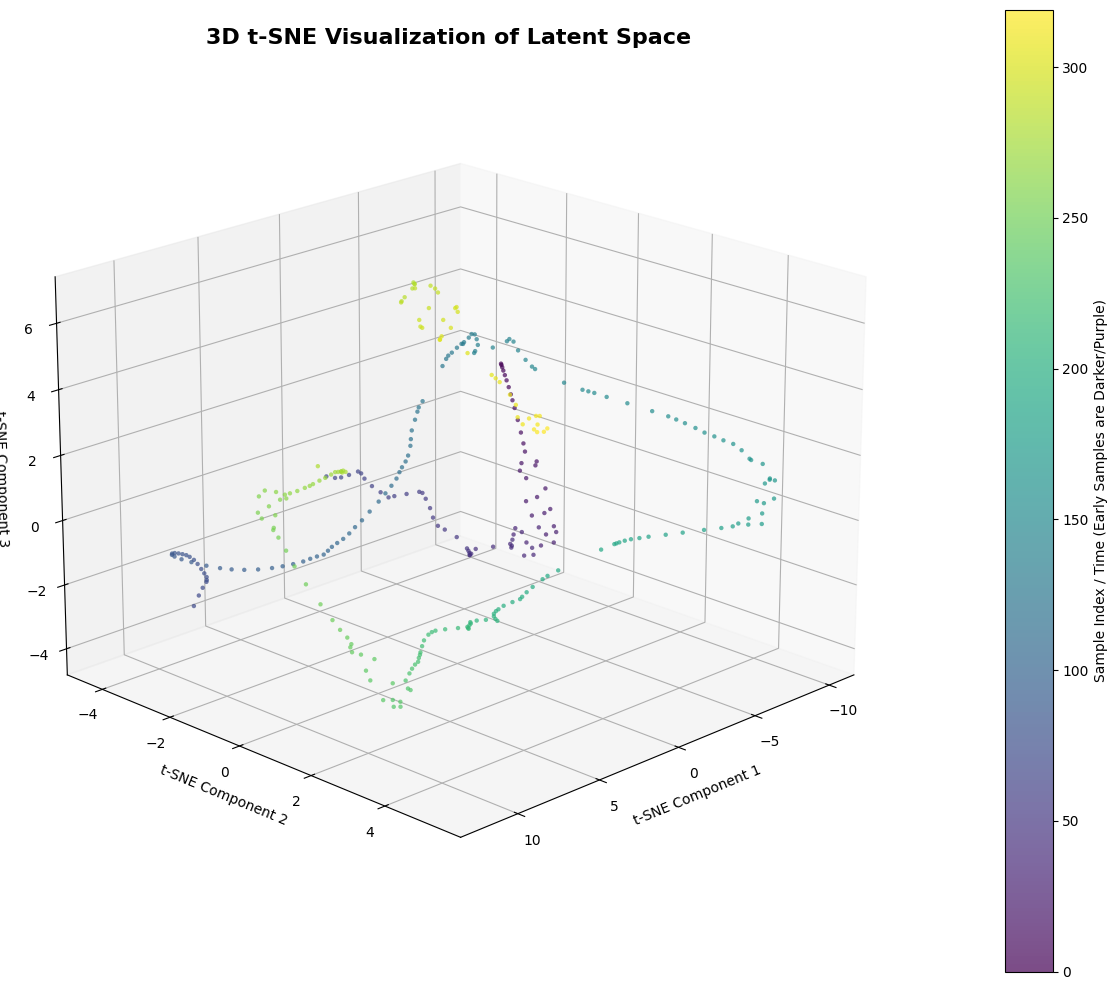

t-SNE 3D visualization displayed successfully.


In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from sklearn.manifold import TSNE
import numpy as np

# Assuming latent_data is defined
print(f"Latent Data Shape: {latent_data.shape}")

# 1. Change n_components to 3
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_jobs=-1)

# Fit and transform the data
print("Running t-SNE...")
tsne_results = tsne.fit_transform(latent_data)
indices = np.arange(tsne_results.shape[0])

# Plotting the results
fig = plt.figure(figsize=(12, 10))

# 2. Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# 3. Scatter plot with x, y, AND z coordinates
# Note: I changed 'c' to 'indices' so the colorbar logic (Time/Index) is actually true.
scatter = ax.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    tsne_results[:, 2], 
    c=indices,  # Using indices so gradient represents time/sequence
    cmap='viridis', 
    s=10, 
    alpha=0.7,
    edgecolors='none'
)

# Colorbar setup
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Sample Index / Time (Early Samples are Darker/Purple)')

# Titles and Axis Labels
ax.set_title('3D t-SNE Visualization of Latent Space', fontsize=16, fontweight='bold')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

# Optional: Change initial viewing angle (elevation, azimuth)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()
print("t-SNE 3D visualization displayed successfully.")

Mode: test, Index list length: 1


100%|██████████| 1/1 [00:00<00:00, 160.39it/s]


Running t-SNE on 1554 samples...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1554 samples in 0.000s...
[t-SNE] Computed neighbors for 1554 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1554
[t-SNE] Computed conditional probabilities for sample 1554 / 1554
[t-SNE] Mean sigma: 0.732476
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.818653
[t-SNE] KL divergence after 1000 iterations: 0.190534


/tmp/ipykernel_291217/136848076.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_noisy = get_cmap('Set1', NUM_NOISY_SAMPLES)


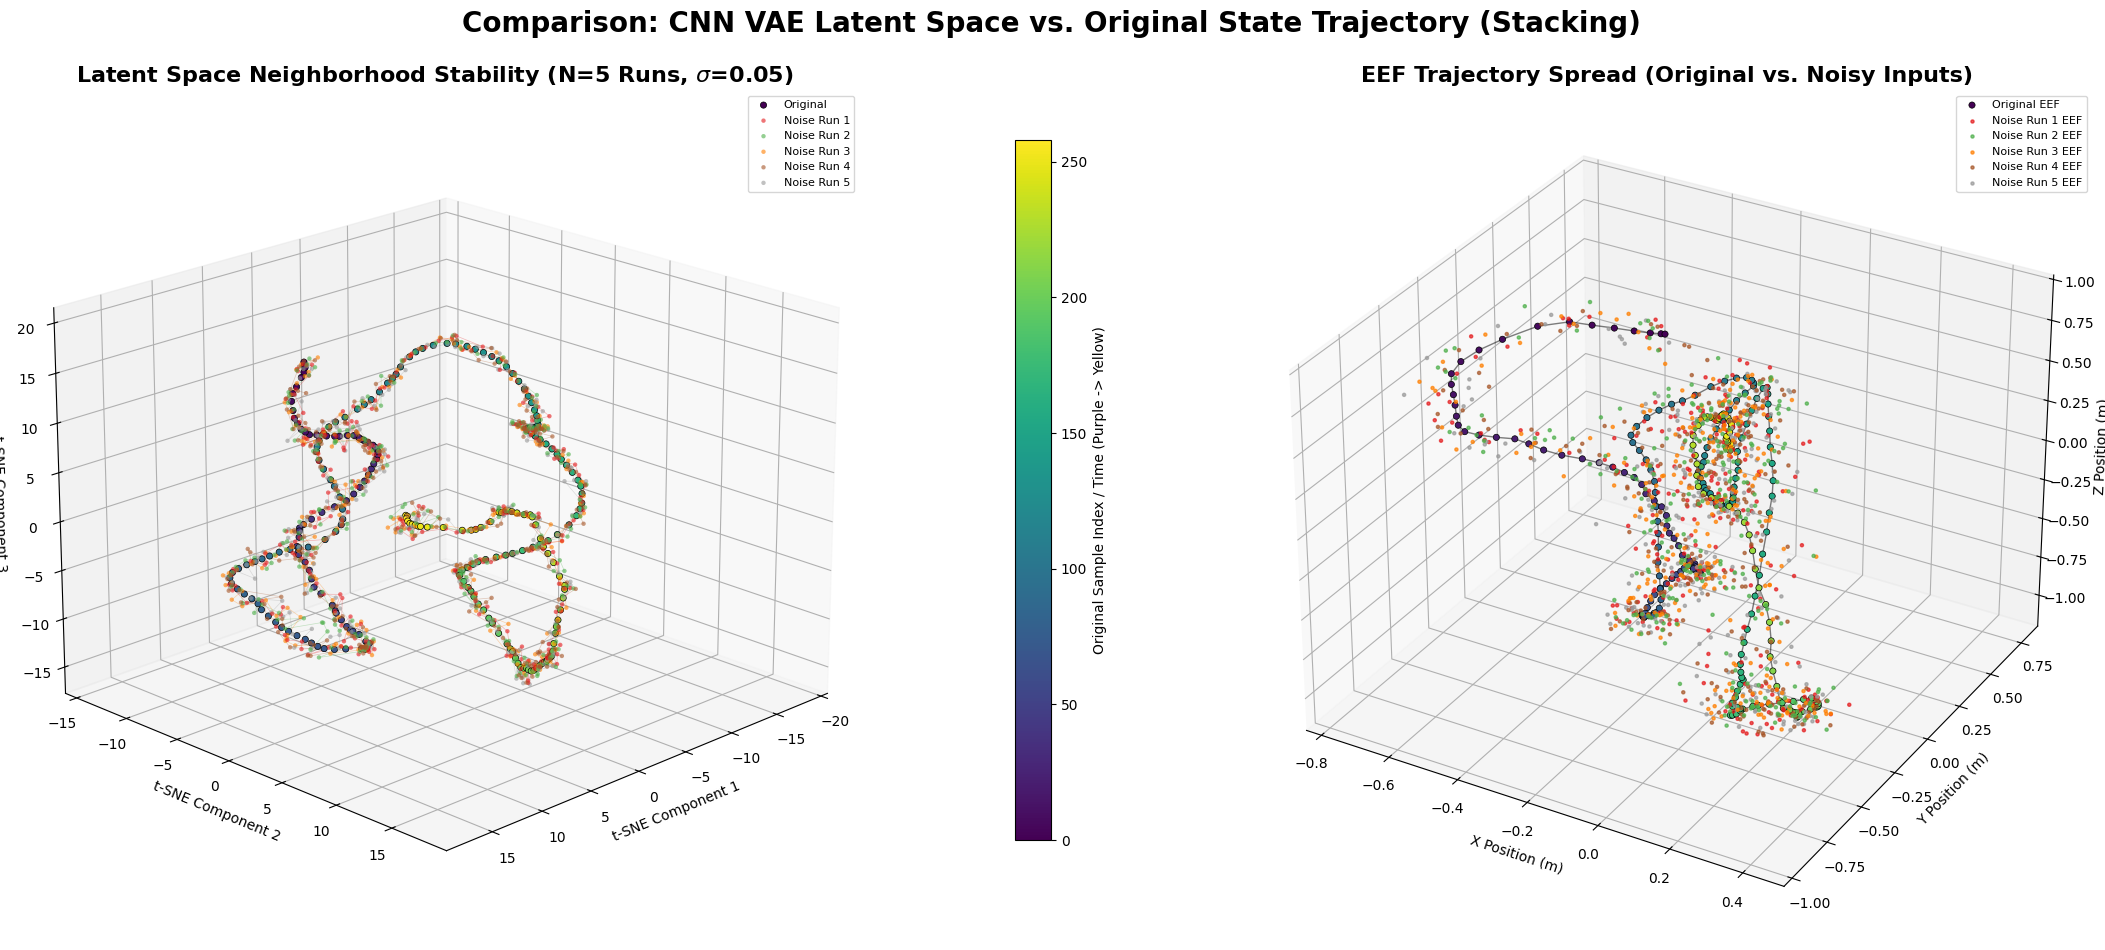

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import torch.nn as nn
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

# --- Configuration ---
src_dir = "/extra_storage/stack_three_latent_actions/buf.pkl"
batch_size = 1 
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 256
channels = [64,128,256]
dec_in_padding = [1, 1, 1]
dec_out_padding = [1, 1, 1]
model = CNN_VAE(ac_chunk, obs_dim[0], ac_dim[-1], channels,dec_in_padding, dec_out_padding, latent_dim)
NOISE_STD = 0.05 # Standard deviation for Gaussian noise applied to state components
NUM_NOISY_SAMPLES = 5 # <--- NEW: Number of noisy trajectories to generate

test_action_dataset = LatentActionBuffer(src_dir, 
                                            1,
                                            10,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = 1, 
                                  shuffle = False, 
                                  num_workers=1) 
# --- Load Model and Data ---
# Assuming LatentActionBuffer, MLPVAE, and DataLoader are defined and ready

state_dict = torch.load("/home/blank/cs282_project/latent_actions/cnn_vae_stacking/checkpoint.pth")
model.load_state_dict(state_dict["model_state_dict"])
model.eval().cuda()

# --- START: Data Capture for Original and Multiple Noisy Samples ---
all_latents_orig = []
all_eef_pos_orig = []
all_latents_multi_noisy = [] # Stores list of arrays for N noisy runs
all_eef_pos_multi_noisy = [] # Stores list of arrays for N noisy runs

counter = 0
for batch in test_loader: 
    states = batch[0] # Original states (e.g., [1, 9, 1])
    actions = batch[1] 

    # Prepare tensors for VAE inference
    states_orig = states.to("cuda").float()
    actions = actions.to("cuda").float()
    
    # Capture Original EEF position
    eef_pos_orig = states[0, :3].detach().cpu().numpy() 
    all_eef_pos_orig.append(eef_pos_orig)

    # VAE Inference for Original Latents
    with torch.no_grad():
        latents_orig = model.enc(states_orig, actions)
        all_latents_orig.append(latents_orig.detach().cpu().numpy().reshape((-1,)))
    
    # --- Generate Multiple Noisy Samples ---
    noisy_latents_i = []
    noisy_eef_pos_i = []
    
    for _ in range(NUM_NOISY_SAMPLES):
        # Create Gaussian noise tensor: shape (1, 9, 1)
        noise = torch.randn_like(states) * NOISE_STD 
        states_noisy_cpu = states + noise
        
        # Capture Noisy EEF position
        eef_pos_noisy = states_noisy_cpu[0, :3].detach().cpu().numpy()
        noisy_eef_pos_i.append(eef_pos_noisy)

        # VAE Inference for Noisy Latents
        states_noisy = states_noisy_cpu.to("cuda").float()
        with torch.no_grad():
            latents_noisy = model.enc(states_noisy, actions)
            noisy_latents_i.append(latents_noisy.detach().cpu().numpy().reshape((-1,)))
    
    all_latents_multi_noisy.append(np.array(noisy_latents_i))
    all_eef_pos_multi_noisy.append(np.array(noisy_eef_pos_i))

    counter+=1
    # OPTIONAL: Limit the number of samples for faster t-SNE during debugging
    # if counter > 1000: break 

# --- Prepare Data for Plotting ---
latent_data_orig = np.array(all_latents_orig)
eef_data_orig = np.array(all_eef_pos_orig)

# The shape of these arrays is now (N_samples, N_runs, Latent_Dim/3)
latent_data_multi_noisy = np.array(all_latents_multi_noisy)
eef_data_multi_noisy = np.array(all_eef_pos_multi_noisy)

indices = np.arange(latent_data_orig.shape[0])
N_samples = latent_data_orig.shape[0]

# --- t-SNE Projection (Run on ALL data together) ---
# Concatenate original (N) + all noisy data (N * NUM_NOISY_SAMPLES)
latent_data_flat_noisy = latent_data_multi_noisy.reshape(-1, latent_dim)
combined_latent_data = np.concatenate([latent_data_orig, latent_data_flat_noisy], axis=0)

tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_jobs=-1, verbose=1)
print(f"Running t-SNE on {combined_latent_data.shape[0]} samples...")
tsne_results_combined = tsne.fit_transform(combined_latent_data) 

# Split results back into original and noisy sets
tsne_orig = tsne_results_combined[:N_samples]
tsne_noisy_flat = tsne_results_combined[N_samples:]
tsne_noisy_multi = tsne_noisy_flat.reshape(N_samples, NUM_NOISY_SAMPLES, 3) # (N_samples, N_runs, 3)

# --- START: 1x2 Plotting with Overlay ---
fig = plt.figure(figsize=(24, 10)) 

# Define a color map for the noisy runs
cmap_noisy = get_cmap('Set1', NUM_NOISY_SAMPLES)

# -----------------
# SUBPLOT 1: 3D t-SNE Latent Space (Overlay)
# -----------------
ax1 = fig.add_subplot(121, projection='3d')

# 1. Plot Original Trajectory (Colored by Time/Index)
scatter_orig_latent = ax1.scatter(
    tsne_orig[:, 0], tsne_orig[:, 1], tsne_orig[:, 2], 
    c=indices, cmap='viridis', s=20, alpha=1.0, edgecolors='k', linewidths=0.5, label='Original'
)

# 2. Plot Noisy Trajectories (Each run gets a different color)
for i in range(NUM_NOISY_SAMPLES):
    # Scatter the points
    ax1.scatter(
        tsne_noisy_multi[:, i, 0], 
        tsne_noisy_multi[:, i, 1], 
        tsne_noisy_multi[:, i, 2], 
        color=cmap_noisy(i), 
        s=10, 
        alpha=0.6, 
        edgecolors='none', 
        label=f'Noise Run {i+1}'
    )
    # Optionally connect points to show the path of the noisy run
    ax1.plot(
        tsne_noisy_multi[:, i, 0], 
        tsne_noisy_multi[:, i, 1], 
        tsne_noisy_multi[:, i, 2], 
        color=cmap_noisy(i), 
 
        alpha=0.3,
        linewidth=0.5
    )

# Titles and Axis Labels
ax1.set_title(f'Latent Space Neighborhood Stability (N={NUM_NOISY_SAMPLES} Runs, $\sigma$={NOISE_STD})', fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_zlabel('t-SNE Component 3')
ax1.view_init(elev=20, azim=45)
ax1.legend(loc='best', fontsize=8)


# -----------------
# SUBPLOT 2: Original 3D EEF Trajectory (Overlay)
# -----------------
ax2 = fig.add_subplot(122, projection='3d')

# 1. Plot Original EEF Trajectory (Colored by Time/Index)
scatter_orig_eef = ax2.scatter(
    eef_data_orig[:, 0], eef_data_orig[:, 1], eef_data_orig[:, 2], 
    c=indices, cmap='viridis', s=20, alpha=1.0, edgecolors='k', linewidths=0.5, label='Original EEF'
)
ax2.plot(eef_data_orig[:, 0], eef_data_orig[:, 1], eef_data_orig[:, 2], 
         color='k', alpha=0.5, linewidth=1.0) # Black line for original

# 2. Plot Noisy EEF Trajectories (Each run gets a different color)
for i in range(NUM_NOISY_SAMPLES):
    # Plot the line trajectory
    ax2.scatter(
        eef_data_multi_noisy[:, i, 0], 
        eef_data_multi_noisy[:, i, 1], 
        eef_data_multi_noisy[:, i, 2], 
        color=cmap_noisy(i), 
        s = 5, 
        alpha=0.7,
        linewidth=1.0,
        label=f'Noise Run {i+1} EEF' # Only label one
    )
    # Scatter points are less necessary here as the line shows the path clearly

# Titles and Axis Labels
ax2.set_title('EEF Trajectory Spread (Original vs. Noisy Inputs)', fontsize=16, fontweight='bold')
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_zlabel('Z Position (m)')
ax2.legend(loc='best', fontsize=8)


# --- Central Colorbar (For Original Trajectory Time Index) ---
cbar_ax = fig.add_axes([0.485, 0.15, 0.015, 0.7]) # [left, bottom, width, height]
cbar = fig.colorbar(scatter_orig_latent, cax=cbar_ax, orientation='vertical')
cbar.set_label('Original Sample Index / Time (Purple -> Yellow)')

fig.suptitle(f'Comparison: CNN VAE Latent Space vs. Original State Trajectory (Stacking)', 
             fontsize=20, fontweight='bold')

plt.subplots_adjust(
    left=0.02, 
    right=0.98,
    bottom=0.05, 
    top=0.90, 
    wspace=0.15, 
    hspace=0.2
)
plt.show()